# 1. Load Dataset and Quick Overview

In [1]:
# import libraries
import pandas as pd
import numpy as np

# load dataset
df = pd.read_csv('../data/ab_data.csv')

# Quick structure check
df.info()

# Display first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# Basic sanity check
print("Number of rows:", len(df))
print("Unique users:", df['user_id'].nunique())
print("Duplicated users:", df['user_id'].duplicated().sum(), "\n")

# Basic group and conversion counts
print(df['group'].value_counts(), "\n")
print(df['converted'].value_counts(), "\n")

# Confirming that `converted` has only 0/1 values, no missing data
df['converted'].value_counts(normalize=True) * 100
print("Numbere of NaN:", df['converted'].isna().sum())

Number of rows: 294478
Unique users: 290584
Duplicated users: 3894 

group
treatment    147276
control      147202
Name: count, dtype: int64 

converted
0    259241
1     35237
Name: count, dtype: int64 

Numbere of NaN: 0


Groups assignment is **balanced** (`treatment` = 147276, `control` = 147202).

We have **3894** duplicated users, they should be deleted.

# 2. Initial cleaning

- removing duplicate `user_id`s
- dropping rows with mismatching `group`/`landing_page` pairs ('control' = 'old_page', 'treatment' = 'new_page')

In [13]:
# removing duplicated
# sorting by timestamp to leave only first occurrences
df = df.sort_values(by='timestamp')

# dropping duplicates
df = df.drop_duplicates(subset=['user_id'], keep='first')

df = df.sort_values(by='timestamp', ascending=False)

# dropping rows with mismatching group/landing_page pairs
# check mismatched combinations
mismatched = df.query(
    "(group == 'treatment' and landing_page != 'new_page') "
    "or (group == 'control' and landing_page != 'old_page')"
)

print("Number of mismatched rows:", len(mismatched))

# dropping mismatches
df = df.drop(mismatched.index)

# double-check that all combinations are now valid
# checking all the existing combinations in dataset after drop
# should have only two:
# control - old_page
# treatment - new_page
df.groupby('group')['landing_page'].value_counts()

Number of mismatched rows: 1949


group      landing_page
control    old_page        144319
treatment  new_page        144316
Name: count, dtype: int64

# 3. Exploratory Data Analysis

- Group, Random Assignment Balance & Conversion Overview
- Quick Visualization

In [11]:
# group sizes
group_counts = df['group'].value_counts()
print("Group sizes:\n", group_counts, "\n")

# percentage split
split_ratio = group_counts / group_counts.sum() * 100
print("Sample size ratio (%):\n", split_ratio.round(2), "\n")

# conversion rate by group
conversion_rates = df.groupby('group')['converted'].mean() * 100
print("Conversion rates (%):\n", conversion_rates, "\n")

# Summary DataFrame
summary = pd.DataFrame({
    'Users': df['group'].value_counts(),
    'Converted (%)': df.groupby('group')['converted'].mean() * 100
})
summary['Converted (%)'] = summary['Converted (%)'].round(2)
summary

Group sizes:
 group
treatment    147276
control      147202
Name: count, dtype: int64 

Sample size ratio (%):
 group
treatment    50.01
control      49.99
Name: count, dtype: float64 

Conversion rates (%):
 group
control      12.039918
treatment    11.891958
Name: converted, dtype: float64 



,Users,Converted (%)
group,,
control,147202,12.04
treatment,147276,11.89


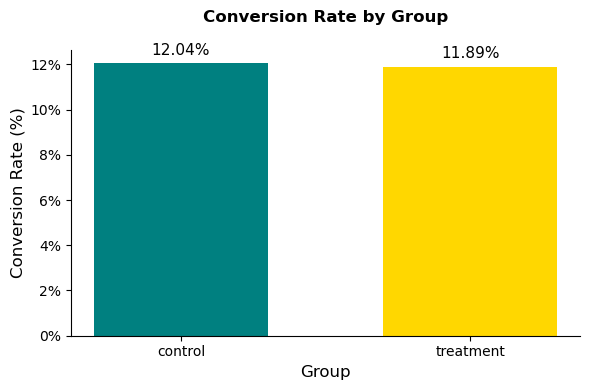

In [ ]:
import matplotlib.pyplot as plt

# Values
groups = conversion_rates.index
rates = conversion_rates.values

plt.figure(figsize=(6,4), facecolor='white')

bars = plt.bar(groups, rates, color=["#008080", "#ffd700"], width=0.6)

# Title and labels
plt.title('Conversion Rate by Group', fontsize=12, weight='bold', pad=20)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Group', fontsize=12)

# Keep only left (y-axis) and bottom (x-axis) spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format y-axis with % sign
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Remove grid lines
plt.grid(False)

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.25,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.tight_layout()
plt.show()


# 4. Statistical Testing (Two-Proportion Z-Test)

We’re testing whether the conversion rate of the `treatment` group (`new_page`) is significantly different from that of the `control` group.

- **H0 (null)** - The new page doesn’t change the conversion rate.
- **H1 (alternativ)** - The new page does change the conversion rate (either up or down).

We’ll test it using a **z-test** for proportions — a standard test when comparing two independent proportions (conversion rates).  
Then we compute the **p-value** from the z-statistic to see if it’s below our significance level *(typically 0.05)*.

In [8]:
from statsmodels.stats.proportion import proportions_ztest

# conversion counts
control_converted = df.query("group == 'control'")['converted'].sum()
treatment_converted = df.query("group == 'treatment'")['converted'].sum()

# sample sizes
n_control = df.query("group == 'control'").shape[0]
n_treatment = df.query("group == 'treatment'").shape[0]

# run two-proportion z-test
count = np.array([treatment_converted, control_converted])
nobs = np.array([n_treatment, n_control])

stat, pval = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {pval:.4f}")

Z-statistic: -1.4036
P-value: 0.1604


## Distribution of Conversions (Counts)

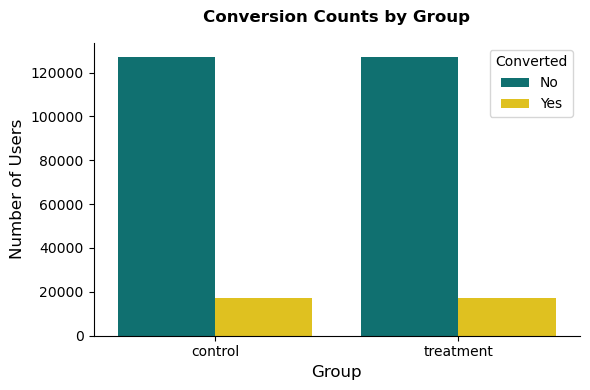

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors
custom_palette = ["#008080", "#ffd700"]  # control, treatment

plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='group',
    hue='converted',
    palette=custom_palette
)
plt.title('Conversion Counts by Group', fontsize=12, weight='bold', pad=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend(title='Converted', labels=['No', 'Yes'])
sns.despine()  # removes top/right borders for a clean look
plt.tight_layout()
plt.show()

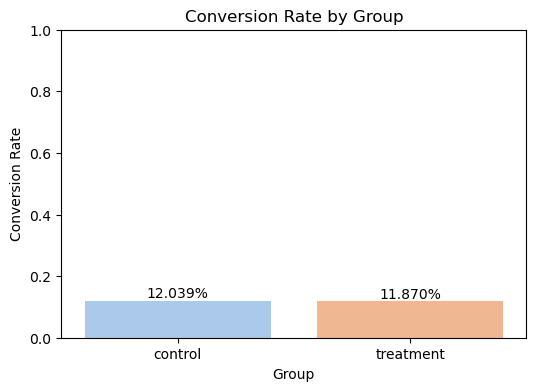

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate conversion rates
conv_rates = df.groupby('group')['converted'].mean().reset_index()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=conv_rates, x='group', y='converted',
            hue='group',
            legend=False, 
            palette='pastel')
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0, 1)
for i, row in conv_rates.iterrows():
    plt.text(i, row.converted + 0.01, f"{row.converted:.3%}", ha='center')
plt.show()


# 5. Confidence Interval Plot (Visualizing Uncertainty)

Once we’ve seen that control and treatment look close, the next step is to quantify how confident we are in that difference.  
We’ll calculate and visualize 95% confidence intervals for each group’s conversion rate — showing the overlap (which visually explains why p≈0.16 → not significant).

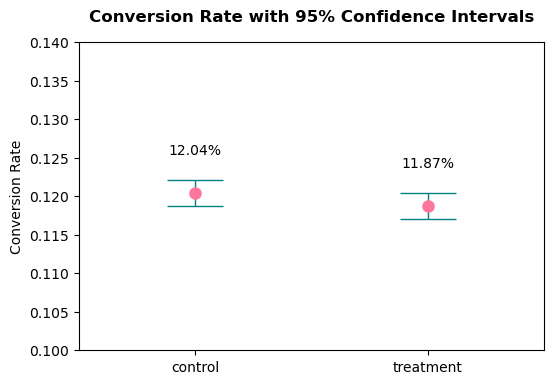

In [60]:
import scipy.stats as st
import matplotlib.pyplot as plt

# Compute conversion rates and confidence intervals
summary = df.groupby('group')['converted'].agg(['mean', 'count'])
summary['std_err'] = np.sqrt(summary['mean'] * (1 - summary['mean']) / summary['count'])
summary['ci_low'], summary['ci_high'] = st.norm.interval(
    0.95, loc=summary['mean'], scale=summary['std_err']
)

# Plot
plt.figure(figsize=(6,4))
plt.errorbar(summary.index, summary['mean'], 
             yerr=summary['mean'] - summary['ci_low'], 
             fmt='o', color="#fe779b", ecolor="#008080", 
             elinewidth=1, capsize=20, markersize=8)
plt.title('Conversion Rate with 95% Confidence Intervals', fontsize=12, weight='bold', pad=15)
plt.ylabel('Conversion Rate')
plt.ylim(0.10, 0.14)

plt.xlim(-0.5, len(summary.index) - 0.5)

for i, val in enumerate(summary['mean']):
    plt.text(i, val + 0.005, f"{val:.2%}", ha='center')
plt.show()


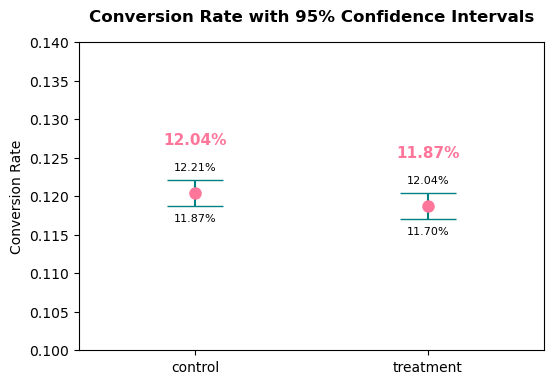

In [62]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

# Compute conversion rates and confidence intervals
summary = df.groupby('group')['converted'].agg(['mean', 'count'])
summary['std_err'] = np.sqrt(summary['mean'] * (1 - summary['mean']) / summary['count'])
summary['ci_low'], summary['ci_high'] = st.norm.interval(
    0.95, loc=summary['mean'], scale=summary['std_err']
)

# Plot
plt.figure(figsize=(6,4))
plt.errorbar(summary.index, summary['mean'], 
             yerr=summary['mean'] - summary['ci_low'], 
             fmt='o', color="#fe779b", ecolor="#008080", 
             elinewidth=1.5, capsize=20, markersize=8)

plt.title('Conversion Rate with 95% Confidence Intervals', fontsize=12, weight='bold', pad=15)
plt.ylabel('Conversion Rate')
plt.ylim(0.10, 0.14)
plt.xlim(-0.5, len(summary.index) - 0.5)

# Add labels for mean (dot), top and bottom caps
for i, row in summary.iterrows():
    # Dot label (mean)
    plt.text(i, row['mean'] + 0.006, f"{row['mean']:.2%}", 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color="#fe779b")
    # Top cap label
    plt.text(i, row['ci_high'] + 0.001, f"{row['ci_high']:.2%}", 
             ha='center', va='bottom', fontsize=8, color="#000000")
    # Bottom cap label
    plt.text(i, row['ci_low'] - 0.001, f"{row['ci_low']:.2%}", 
             ha='center', va='top', fontsize=8, color="#000000")

plt.show()

# 6. Lift Analysis (Business Impact)

It shows how much better or worse the treatment performed relative to the control (%).

Lift: -1.41%


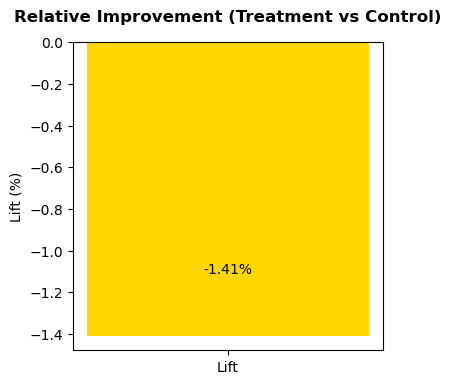

In [65]:
# Calculate conversion rates
conv_control = summary.loc['control', 'mean']
conv_treatment = summary.loc['treatment', 'mean']

# Calculate lift
lift = (conv_treatment - conv_control) / conv_control * 100
print(f"Lift: {lift:.2f}%")

# Visualize
plt.figure(figsize=(4,4))
plt.bar(['Lift'], [lift], color="#ffd700")
plt.axhline(0, color='#dbdbdb', linestyle='--')
plt.ylabel('Lift (%)')
plt.title('Relative Improvement (Treatment vs Control)', fontsize=12, weight='bold', pad=15)
plt.text(0, lift + 0.3, f"{lift:.2f}%", ha='center')
plt.show()


## Interpretation

Lift shows **−1.41%**, that means:

    The new (treatment) landing page **converted about 1.41% fewer users than the original** (control).

**However,** since your p-value = 0.16, that **difference isn’t statistically significant** — meaning it could easily be random variation.

# 7. Project Summary



## df-to-markdown

In [3]:
def df_to_markdown(df, name, max_rows=10):
    print(f"### {name} Dataset ({len(df)} rows, {len(df.columns)} columns)")
    print("| " + " | ".join(df.columns.astype(str)) + " |")
    print("|" + "|".join(["---"] * len(df.columns)) + "|")
    
    for i in range(min(max_rows, len(df))):
        row = " | ".join([str(x) for x in df.iloc[i].values])
        print(f"| {row} |")
    print()

# df, title
df_to_markdown(df.head(5), "Overview")

### Overview Dataset (5 rows, 5 columns)
| user_id | timestamp | group | landing_page | converted |
|---|---|---|---|---|
| 851104 | 2017-01-21 22:11:48.556739 | control | old_page | 0 |
| 804228 | 2017-01-12 08:01:45.159739 | control | old_page | 0 |
| 661590 | 2017-01-11 16:55:06.154213 | treatment | new_page | 0 |
| 853541 | 2017-01-08 18:28:03.143765 | treatment | new_page | 0 |
| 864975 | 2017-01-21 01:52:26.210827 | control | old_page | 1 |

